In [180]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import XLMRobertaTokenizer, XLMRobertaModel

In [182]:
# change path to Dataset file
df = pd.read_csv('D:\\Master 2 TAL\\Neural networks\\dataset.csv')
df.loc[:,'language'].unique()

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portugese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

## Data Encoding and Pre-prrocessing ( Using BERT Embeddings : Intensive Calculation ) 

In [184]:
# enconding labels of langauges into unique numbers of their own: each number represents a language
le = LabelEncoder()
text_labels = df.iloc[:, 1]

# Fit transform the labels
encoded_labels = le.fit_transform(text_labels)

# Creating a mapping between original labels and encoded labels
label_mapping = dict(zip(text_labels, encoded_labels))

# To find which label is encoded with a certain number, you can invert the mapping
# Let's say you want to find which label is encoded with number 0
encoded_label_to_find = 0
for label, encoded_label in label_mapping.items():
    if encoded_label == encoded_label_to_find:
        print(f"The label '{label}' is encoded as {encoded_label_to_find}")

The label 'Arabic' is encoded as 0


### Contextual embeddings extraction : ( if got embeddings, ignore ) This scenario  = XLM-RoBERTA

In [810]:
## Initializing BertTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
model = XLMRobertaModel.from_pretrained('xlm-roberta-large')

In [812]:
#preparing BERT's word IDs to extract pre-trained embeddings
total_ids = []
attention_masks = []

# For every sentence...
for sent in df.iloc[:, 0]:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to split into tokens
                        add_special_tokens=True,   # Add special token '[CLS]' and '[SEP]'
                        max_length=512,             # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask=True,   # Construct attention masks.
                        return_tensors='pt',       # Return PyTorch tensors.
                   )
    
    # Adding the encoded sentence to the list.    
    total_ids.append(encoded_dict['input_ids'])
    
    # Attention mask (to differentiate padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Kovaech\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [814]:
from torch.utils.data import DataLoader, TensorDataset


model = model.to(device)

# Assuming total_ids and attention_masks are lists of tensors obtained from the encoding process
input_ids = torch.cat(total_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

dataset = TensorDataset(input_ids, attention_masks)

batch_size = 64 # Adjust based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size)

model.eval()  
xlmroberta_embeddings = []

with torch.inference_mode():
    for batch in dataloader:

        b_input_ids, b_attention_mask = batch[0].to(device), batch[1].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]  
        xlmroberta_embeddings.append(embeddings.cpu())  

# Concatenate the embeddings from each batch
xlmroberta_embeddings = torch.cat(xlmroberta_embeddings, dim=0)

In [816]:
xlmroberta_embeddings.shape

torch.Size([22000, 1024])

In [818]:
# saving embeddings and labels of the data inside the computer for outside use
data_to_save = xlmroberta_embeddings

# Save variables to a file using pickle
with open('D:\\Master 2 TAL\\Neural networks\\project\\xlmroberta_embeddings.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

## Loading embeddings and preparing Data

In [186]:
# loading saved embeddings of BERT
import pickle

# Specify the path to your pickle file
pickle_file_path = 'D:\\Master 2 TAL\\Neural networks\\project\\xlmroberta_embeddings.pkl'

# Open the pickle file in binary read mode ('rb')
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    loaded_embeddings = pickle.load(file)

In [188]:
## Defining Variables of features and labels to be fed into the model for training 
X_features = loaded_embeddings
y_labels = encoded_labels
X_features = torch.Tensor(X_features)
y_labels_tensor = torch.Tensor(y_labels)

In [190]:
print('shape of x embeddings: ',X_features.shape)
print('shape of y labels: ',y_labels_tensor.shape)

shape of x embeddings:  torch.Size([22000, 1024])
shape of y labels:  torch.Size([22000])


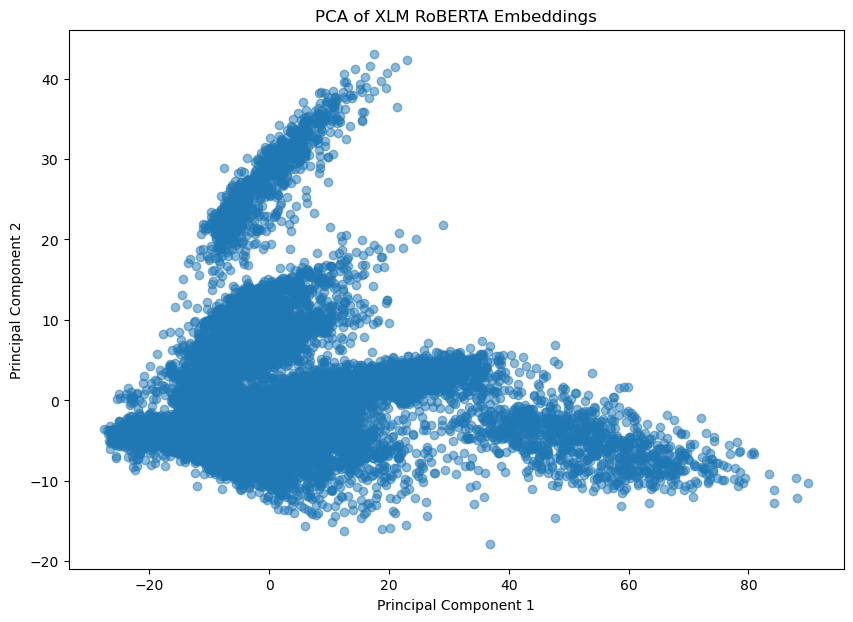

In [192]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X_tensor is your [22000, 768] PyTorch tensor
# Generate some random data for demonstration purposes
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array
X_np = X_features.numpy()

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of XLM RoBERTA Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

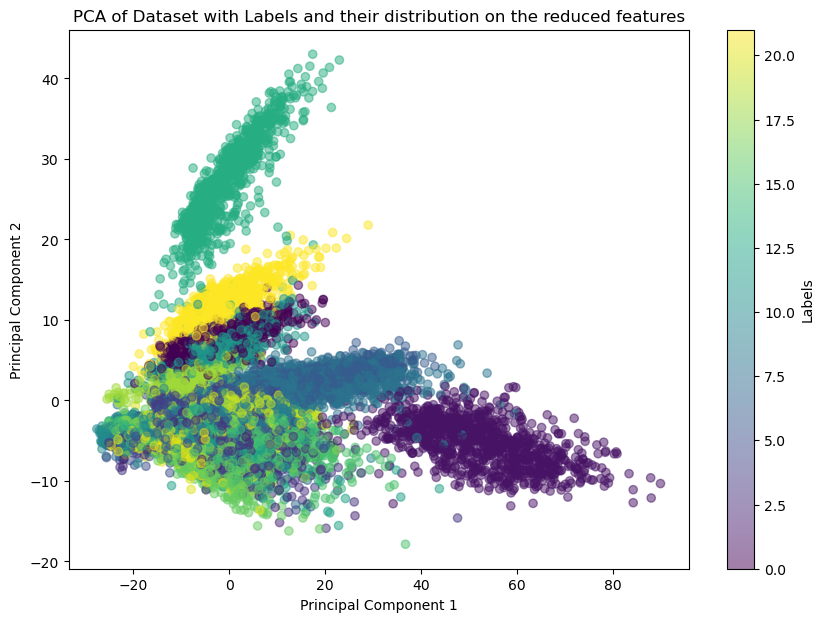

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the labels tensor to a NumPy array for plotting
y_np = y_labels_tensor.numpy()

# Assuming X_pca is the PCA-reduced data you computed earlier
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_np, alpha=0.5, cmap='viridis')
plt.title('PCA of Dataset with Labels and their distribution on the reduced features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Labels')
plt.show()


In [17]:
# Setting up device agnostic Tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
X_features= X_features.to(device) 
y_labels_tensor= y_labels_tensor.type(torch.LongTensor)
y_labels_tensor= y_labels_tensor.to(device)

In [21]:
X_features.device, y_labels_tensor.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [23]:

#(70% training, 30% for temp)
X_train, X_temp, y_train, y_temp = train_test_split(X_features, y_labels_tensor, test_size=0.3, random_state=42)

#(50% validation, 50% test from the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [25]:
len(X_train),len(X_test),len(y_train),len(y_test)

(15400, 3300, 15400, 3300)

In [27]:
y_train = y_train.to(device)
y_test = y_test.to(device)

In [29]:
y_test.device,y_train.device

(device(type='cuda', index=0), device(type='cuda', index=0))

## Construct a Feed forward Neural Network + Training

In [127]:
language_identified_model = nn.Sequential(
    nn.Linear(1024, 512),  # First layer
    nn.ReLU(),             # Activation function
    nn.BatchNorm1d(512),   # Batch normalization
    nn.Dropout(0.6),       # Increased dropout for regularization
    
    nn.Linear(512, 256),   # Additional hidden layer
    nn.ReLU(),             # Activation function
    nn.BatchNorm1d(256),   # Batch normalization
    nn.Dropout(0.4),       # Increased dropout for regularization
    
    nn.Linear(256, 128),   # Additional hidden layer
    nn.ReLU(),             # Activation function
    nn.BatchNorm1d(128),   # Batch normalization
    nn.Dropout(0.3),       # Increased dropout for regularization
    
    nn.Linear(128, 64),    # Additional hidden layer
    nn.ReLU(),             # Activation function
    nn.BatchNorm1d(64),    # Batch normalization
    nn.Dropout(0.3),       # Increased dropout for regularization
    
    nn.Linear(64, 22),     # Output layer for 22 classes
)

In [135]:
language_identified_model = language_identified_model.to(device)

In [129]:
loss_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(language_identified_model.parameters(), lr=0.01,momentum=0.9)

In [131]:
language_identified_model

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.6, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=64, out_features=22, bias=True)
)

In [137]:
epochs = 300
epoch_count = []
train_losses = []
val_losses = []  
test_losses = []
train_accuracies = []  # Store training accuracies
val_accuracies = []  # Validation accuracies
test_accuracies = []  # Store test accuracies
best_val_loss = float('inf')  # track the best model
best_model_state = language_identified_model.state_dict()  # Initialize best_model_state

for epoch in range(epochs):
    epoch_count.append(epoch)
    
    # Training phase
    language_identified_model.train()
    initial_preds = language_identified_model(X_train)
    train_loss = loss_entropy(initial_preds, y_train)
    train_losses.append(train_loss.item())  # Ensure to call .item() for scalar value
    
    # Calculate training accuracy
    _, predicted_labels_train = torch.max(initial_preds, 1)
    correct_train = (predicted_labels_train == y_train).float().sum()
    train_accuracy = (correct_train / y_train.size(0)) * 100
    train_accuracies.append(train_accuracy.item())
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    language_identified_model.eval()
    with torch.inference_mode():
        val_pred = language_identified_model(X_val)
        val_loss = loss_entropy(val_pred, y_val)
        val_losses.append(val_loss.item())
        
        _, predicted_labels_val = torch.max(val_pred, 1)
        correct_val = (predicted_labels_val == y_val).float().sum()
        val_accuracy = (correct_val / y_val.size(0)) * 100
        val_accuracies.append(val_accuracy.item())
        
        # Update best model if current validation loss is lower
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = language_identified_model.state_dict()
            
    
    if (epoch + 1) % 100 == 0:  # Print status
        print(f"** Epoch {epoch + 1}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

language_identified_model.load_state_dict(best_model_state) #load the best model for final evaluation on test set
language_identified_model.eval()
with torch.inference_mode():
    test_pred = language_identified_model(X_test)
    test_loss = loss_entropy(test_pred, y_test)
    _, predicted_labels_test = torch.max(test_pred, 1)
    correct_test = (predicted_labels_test == y_test).float().sum()
    test_accuracy = (correct_test / y_test.size(0)) * 100
    
    print(f"Final Test Loss: {test_loss.item():.5f}, Test Accuracy: {test_accuracy.item():.2f}%")


** Epoch 100: Train Loss: 0.19243, Val Loss: 0.09407, Train Accuracy: 98.01%, Val Accuracy: 98.18%
** Epoch 200: Train Loss: 0.11389, Val Loss: 0.07582, Train Accuracy: 98.42%, Val Accuracy: 98.39%
** Epoch 300: Train Loss: 0.08694, Val Loss: 0.06770, Train Accuracy: 98.64%, Val Accuracy: 98.45%
Final Test Loss: 0.07894, Test Accuracy: 98.45%


In [143]:
best_val_loss


tensor(0.0677, device='cuda:0')

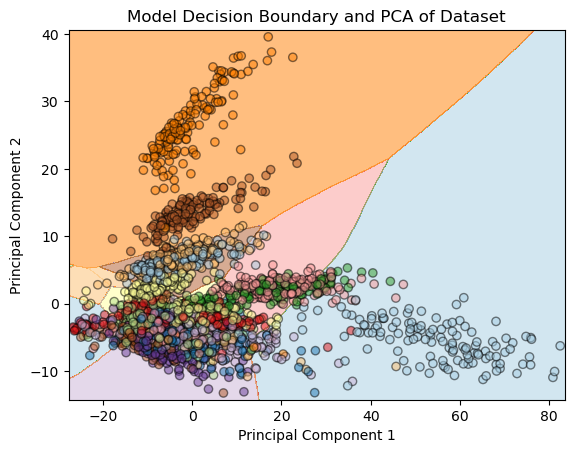

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X_tensor is your [22000, 768] PyTorch tensor and you have a corresponding labels tensor y_tensor
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array for features and labels
X_np = X_test.cpu().numpy()  # Move X_test tensor to CPU and then convert to NumPy array
y_np = y_test.cpu().numpy()  # Move y_test tensor to CPU and then convert to NumPy array


# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to plot decision boundary for a PyTorch model
def plot_decision_boundary_pytorch(X, y, model, device, steps=1000, cmap='Paired'):
    model.to(device)
    model.eval()  # Put the model in evaluation mode
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))

    # Preprocess grid points
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_original_space = pca.inverse_transform(grid)  # Transform back to original space
    grid_original_space = scaler.inverse_transform(grid_original_space)  # Inverse scaling
    grid_tensor = torch.tensor(grid_original_space, dtype=torch.float).to(device)

    # Predict using the PyTorch model
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        preds = np.argmax(preds, axis=1).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, preds, alpha=0.5, levels=np.unique(y), cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, edgecolor='k', cmap=cmap)
    plt.title('Model Decision Boundary and PCA of Dataset')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming `model` is your trained PyTorch model and `device` is your device ('cuda' or 'cpu')
plot_decision_boundary_pytorch(X_pca, y_np, language_identified_model, device='cuda')  # Adjust 'cpu' to 'cuda' if using GPU


In [147]:
#loading the model's best state_dict from the trainig loop
language_identified_model.load_state_dict(best_model_state)
language_identified_model

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.6, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=64, out_features=22, bias=True)
)

In [153]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(epochs, train_loss, test_loss, title='Training and Val Loss', smooth_factor=0.6):
    """
    Plot the smoothed training and test loss over epochs.

    Parameters:
    - epochs: Number of epochs or a list of epoch indices.
    - train_loss: List or array of training loss values.
    - test_loss: List or array of test loss values.
    - title: Title of the plot.
    - smooth_factor: The weight factor for exponential moving average smoothing.
    """
    def smooth_curve(points, factor=smooth_factor):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    if isinstance(epochs, int):
        epochs = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, smooth_curve(train_loss), label='Train Loss', marker='o')
    plt.plot(epochs, smooth_curve(test_loss), label='Val Loss', marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

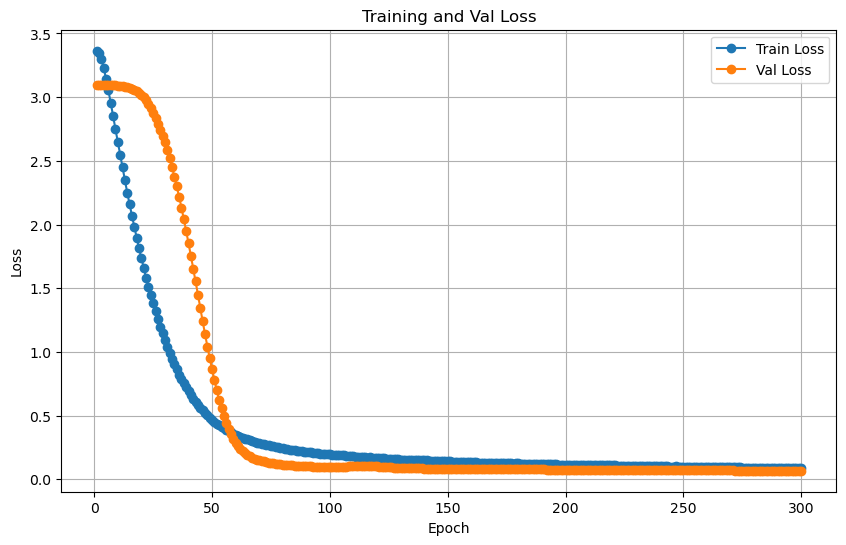

In [155]:
train_loss = []
val_loss = []
for train,val in zip(train_losses,val_losses):
    tensor_train = train
    tensor_val = val
    train_loss.append(tensor_train)
    val_loss.append(tensor_val)
plot_loss(epochs,train_loss,val_loss)

In [159]:
# saving model's parameter's in Local Machine
model_save_path = 'D:\\Master 2 TAL\\Neural networks\\project\\models\\my_model_parameters.pth'
torch.save(language_identified_model.state_dict(), model_save_path)

## Testing Model Prediction

In [161]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
model = XLMRobertaModel.from_pretrained('xlm-roberta-large')


In [162]:
sentence = "أنا هكذا"

In [163]:
# Tokenizing and encoding raw sentence into tensor embeddings from DistilBert
encoded_input = tokenizer(sentence, return_tensors='pt')
output = model(**encoded_input)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0672,  0.0190,  0.0582,  ...,  0.0004, -0.0218, -0.0021],
         [ 0.1297, -0.0495,  0.0434,  ...,  0.1090, -0.2034,  0.0311],
         [-0.0600,  0.0101, -0.0630,  ...,  0.1861, -0.0944,  0.2279],
         [ 0.0381, -0.0157,  0.1664,  ...,  0.1603, -0.0601,  0.2286]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.7741, -0.5208,  0.4815,  ..., -0.6130,  0.3686,  0.1583]],
       grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

In [164]:
# loading Bert tensor embeddings from DistilBert
sentence_embedding = output.last_hidden_state[:, 0, :]

In [165]:
# checking if the shape matches
sentence_embedding.shape

torch.Size([1, 1024])

In [166]:
# predicting using the model
language_identified_model.eval()
with torch.inference_mode():
    logits = language_identified_model(sentence_embedding.to(device))
logits

tensor([[-0.4374, -2.1410,  0.9548, -0.8853, -0.1261, -0.1707, -0.4997,  2.5260,
         -0.4268, -0.0906,  1.2432, -1.3131, -0.1108, -2.0496,  0.8467, -0.4156,
          0.3646, -1.6845,  2.2344, -0.2213,  0.6420,  0.9564]],
       device='cuda:0')

In [167]:
preds = torch.softmax(logits,dim=1)
preds

tensor([[0.0146, 0.0027, 0.0588, 0.0093, 0.0199, 0.0191, 0.0137, 0.2829, 0.0148,
         0.0207, 0.0784, 0.0061, 0.0203, 0.0029, 0.0528, 0.0149, 0.0326, 0.0042,
         0.2113, 0.0181, 0.0430, 0.0589]], device='cuda:0')

In [168]:
# Checking if it is the language used
predicted_index = preds.argmax()  # This finds the index of the maximum value in preds tensor, which is 0 in your case.
predicted_label = encoded_labels[predicted_index]
for label, encoded_label in label_mapping.items():
    if encoded_label == predicted_label:
        print(f"The language Predicted by the model is :{label}")

The language Predicted by the model is :Latin
